# Image Captioning on the ARMBench Dataset using Autoencoders

**The Image Captioning is carried out on the ARMBench Dataset here using Autoencoders and Nearest Neighbours**

The necessary libraries are imported

In [1]:
import pandas as pd #Import necessary libraries
import numpy as np
import json
import os
import cv2
import string
import nltk
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from keras.models import Model
from keras.losses import mean_squared_error
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
from sklearn.utils import resample
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

C:\Users\sahre\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
from sklearn.utils import resample
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sahre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Preprocessing

In [5]:
import pandas as pd
import os
os.chdir('D:/Down') #Replace the location to where the output.csv file is stored.
df = pd.read_csv('output.csv')

Here, the first 50000 images are used and image paths are added to the dataframe. 

In [6]:
import os
import pandas as pd

# Set the base path to the location where the folders of all the ARMBench Dataset images are present
base_path = 'D:/Down/armbench-object-id-0.1/Picks'

def find_one_file(folder_path):
    for root, _, files in os.walk(folder_path):
        if files:  
            return root
    return None


folder_paths = [os.path.join(base_path, folder_name) for folder_name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder_name))]


folder_paths = folder_paths[:50000] #Select first 50000 folder paths


image_paths = [find_one_file(folder_path) for folder_path in folder_paths]


df['image'] = image_paths


The images and captions are preprocessed.

In [7]:
import os
import cv2
from skimage.transform import resize
from skimage.color import gray2rgb

def preprocess_image(image_folder, target_size=(64, 64)): #Resize images to 64x64 
    try:
        pick_rgb_file = os.path.join(image_folder, 'PickRGB') #Use pickrgb images
        if os.path.exists(pick_rgb_file):
            image_path = pick_rgb_file
        else:
            image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and
                           f.lower().endswith(('.jpg', '.jpeg', '.png'))] #if Pickrgb not present, any other image file is chosen
            if not image_files:
                raise Exception("No image files found in the folder.")
            image_path = os.path.join(image_folder, image_files[0])

        img = cv2.imread(image_path)
        if img is None:
            raise Exception(f"Failed to read the image at path: {image_path}")

        if len(img.shape) == 2:
            img = gray2rgb(img)

        img_resized = resize(img, target_size, mode='reflect', anti_aliasing=True)
        return img_resized
    except Exception as e:
        print("Error during image preprocessing:", e)
        return None


In [8]:
def preprocess_caption(caption):
    # Lowercase
    caption = caption.lower()
    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords and lemmatize
    words = caption.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [9]:
import pandas as pd

unique_categories = df['Dominant_Topic'].unique()
print("Unique Categories")
print(unique_categories)


Unique Categories
[ 6 12  0 13  3  5 14  8 17  9  4 10 16  1 15 11  7  2]


The Dominant Topic value counts are printed for the top 10 categories.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
df = df.drop_duplicates() 

category_freq = df['Dominant_Topic'].value_counts()  #Dominant Topic Counts

top_10_categories = category_freq.nlargest(10).index.tolist()

print(category_freq[top_10_categories])

Dominant_Topic
12    6232
13    5381
11    4013
5     3851
3     3789
17    3288
1     3208
4     2982
8     2424
2     2185
Name: count, dtype: int64


2000 Samples are selected from all 10 categories and category distibution is plotted on a bar chart.

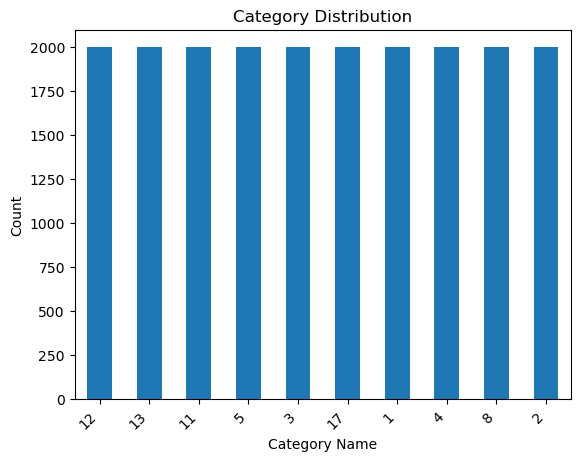

In [11]:

df_ = pd.DataFrame()


for Dominant_Topic in top_10_categories:
    category_data = df[df['Dominant_Topic'] == Dominant_Topic].head(2000)
    df_ = pd.concat([df_, category_data])

df_.reset_index(drop=True, inplace=True)


category_counts = df_['Dominant_Topic'].value_counts() 


category_counts.plot(kind='bar') #Plotting the value counts
plt.title('Category Distribution')
plt.xlabel('Category Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') 
plt.show()

In [12]:
df = df_.copy()

After preprocessing the data, the data issplit into training, testing, and validation splits.

In [13]:
from sklearn.model_selection import train_test_split

df_train_temp, df_temp = train_test_split(df, test_size=0.2, random_state=42) #Data splitting

df_validation, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
df_test2 = df_test.copy()
df_validation2 = df_validation.copy()

def preprocess_data(df): #Data preprocessing
    df['image'] = df['image'].apply(preprocess_image)
    df['caption_preprocessed'] = df['Container'].apply(preprocess_caption)
    df = df.dropna(subset=['image'])
    return np.array(df['image'].tolist()), df

x_train, df_train = preprocess_data(df_train_temp) 
x_validation, df_validation = preprocess_data(df_validation)
x_test, df_test = preprocess_data(df_test)


## Autoencoder

The autoencoder architecture (encoder and decoder) is defined and run for 100 epochs with a batch size of 128

In [14]:
input_img = Input(shape=(64, 64, 3))  #encoder architecture

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)



x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded) #decoder architecture
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, shuffle=True, validation_data=(x_test, x_test)) #training the model

Epoch 1/100
125/125 [==============================] - 40s 317ms/step - loss: 0.5180 - val_loss: 0.4738
Epoch 2/100
125/125 [==============================] - 39s 316ms/step - loss: 0.4684 - val_loss: 0.4673
Epoch 3/100
125/125 [==============================] - 39s 315ms/step - loss: 0.4631 - val_loss: 0.4632
Epoch 4/100
125/125 [==============================] - 39s 315ms/step - loss: 0.4603 - val_loss: 0.4611
Epoch 5/100
125/125 [==============================] - 39s 315ms/step - loss: 0.4582 - val_loss: 0.4592
Epoch 6/100
125/125 [==============================] - 39s 313ms/step - loss: 0.4564 - val_loss: 0.4577
Epoch 7/100
125/125 [==============================] - 39s 310ms/step - loss: 0.4551 - val_loss: 0.4563
Epoch 8/100
125/125 [==============================] - 38s 306ms/step - loss: 0.4538 - val_loss: 0.4557
Epoch 9/100
125/125 [==============================] - 38s 302ms/step - loss: 0.4530 - val_loss: 0.4548
Epoch 10/100
125/125 [==============================] - 38s 300m

125/125 [==============================] - 38s 300ms/step - loss: 0.4462 - val_loss: 0.4483
Epoch 80/100
125/125 [==============================] - 38s 301ms/step - loss: 0.4461 - val_loss: 0.4483
Epoch 81/100
125/125 [==============================] - 37s 299ms/step - loss: 0.4461 - val_loss: 0.4484
Epoch 82/100
125/125 [==============================] - 37s 297ms/step - loss: 0.4462 - val_loss: 0.4483
Epoch 83/100
125/125 [==============================] - 37s 299ms/step - loss: 0.4460 - val_loss: 0.4483
Epoch 84/100
125/125 [==============================] - 38s 300ms/step - loss: 0.4460 - val_loss: 0.4483
Epoch 85/100
125/125 [==============================] - 37s 297ms/step - loss: 0.4461 - val_loss: 0.4482
Epoch 86/100
125/125 [==============================] - 38s 300ms/step - loss: 0.4461 - val_loss: 0.4481
Epoch 87/100
125/125 [==============================] - 38s 300ms/step - loss: 0.4460 - val_loss: 0.4483
Epoch 88/100
125/125 [==============================] - 37s 297ms/st

In [15]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('max_pooling2d_1').output)
x_train_encoded = encoder.predict(x_train) #encoded images
x_test_encoded = encoder.predict(x_test)

63/63 [==============================] - 1s 9ms/step


1/1 [==============================] - 0s 128ms/step


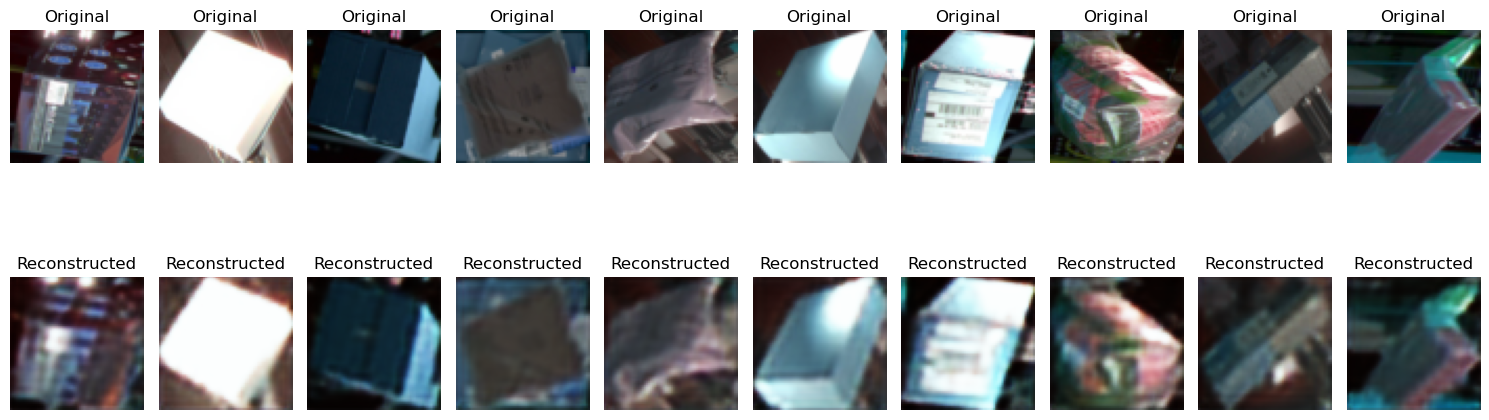

In [17]:
#visualising the original and reconstructed images
num_images_to_visualize = 10
random_indices = np.random.randint(0, len(x_test), num_images_to_visualize)
images_to_visualize = x_test[random_indices]


reconstructed_images = autoencoder.predict(images_to_visualize)

plt.figure(figsize=(15, 6))
for i in range(num_images_to_visualize):
    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(images_to_visualize[i])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, num_images_to_visualize, num_images_to_visualize + i + 1)
    plt.imshow(reconstructed_images[i])
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()

The Reconstruction Loss is calculated using the Mean Squared Error Loss.

In [18]:

reconstructed_images = autoencoder.predict(x_test)

# Calculate the Mean Squared Error (MSE) loss
mse_loss = mean_squared_error(x_test, reconstructed_images)

average_mse_loss = np.mean(mse_loss)
print("Average MSE Loss:", average_mse_loss)

63/63 [==============================] - 1s 15ms/step
Average MSE Loss: 0.0026646252


## Nearest Neighbours

The encoded images are flattened and fitted in the Nearest Neighbor Model.

In [18]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


x_train_flat = x_train.reshape(x_train_encoded.shape[0], -1) #fitting the encoded images to Nearest Neighbours

neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(x_train_flat)




NearestNeighbors()

Here, a random image is visualised and the true and nearest neighbour caption is printed.

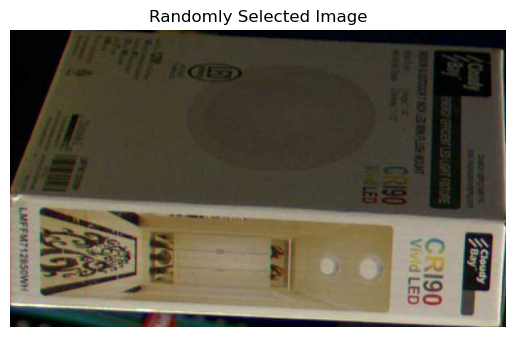

True caption for the randomly selected image: Cloudy Bay 7.5 inch LED Ceiling Light,12W 840lm,5000K Day Light,LED Flush Mount,White Finish,Wet Location
Generated caption for the randomly selected image: Zinnze Solar Lamp Post Light Outdoor Waterproof，Solar Outdoor Post Light with 3.5in Pier Mount Base，Matte Black


In [20]:
import os
from PIL import Image
random_index = np.random.randint(0, len(df_test))
def get_image_path_from_directory(directory): #visualising a random image
    pick_rgb_file = os.path.join(directory, 'PickRGB')
    if os.path.exists(pick_rgb_file):
        return pick_rgb_file

    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg'))]
    if image_files:
        return os.path.join(directory, image_files[0])

    return None 

image_path = df_test2.iloc[random_index]['image']
chosen_image_path = get_image_path_from_directory(image_path)
if chosen_image_path:
    random_image = Image.open(chosen_image_path)
else:
    print(f"No suitable image found in directory: {image_path}")
random_image = Image.open(chosen_image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off')
plt.show()
random_image = x_test[random_index]

random_image_flat = random_image.reshape(1, -1)

distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['Container'].values

generated_caption = neighbor_captions[0] # Predicting the caption of the closest neighbor of the image

true_caption = df_test.iloc[random_index]['Container']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the *Test* Set.

In [19]:
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_test):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['Container'].values
    true_caption = df_test.iloc[i]['Container']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_test)
average_meteor_score_average = total_meteor_score_average / len(x_test)
average_meteor_score_median = total_meteor_score_median / len(x_test)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")


Average METEOR Score using Closest Neighbor: 0.05279477875654958
Average METEOR Score using Average Distance: 0.04936215083065026
Average METEOR Score using Median Distance: 0.04924084993953677


Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the Validation Set.

In [22]:
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_validation):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['Container'].values
    true_caption = df_validation.iloc[i]['Container']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_validation)
average_meteor_score_average = total_meteor_score_average / len(x_validation)
average_meteor_score_median = total_meteor_score_median / len(x_validation)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")

Average METEOR Score using Closest Neighbor: 0.051773965284093094
Average METEOR Score using Average Distance: 0.04913194977500479
Average METEOR Score using Median Distance: 0.04822449631295824


## Hyperparameter Tuning

Hyperparameter Tuning is carried out to choose the most optimal distance metric.

In [23]:
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

metrics_to_test = ['minkowski', 'manhattan', 'euclidean', 'cosine'] #distance metrics to test


n_neighbors_fixed = 5

best_score = float('inf')
best_metric = None


for metric in metrics_to_test:
    neighbors = NearestNeighbors(n_neighbors=n_neighbors_fixed, metric=metric) 
    neighbors.fit(x_train_flat)
    

    distances, _ = neighbors.kneighbors(x_train_flat, n_neighbors=1)
    mean_distance = distances.mean()
    
    if mean_distance < best_score:
        best_score = mean_distance
        best_metric = metric

print("Best metric:", best_metric)

Best metric: manhattan


The encoded images are fitted again using the manhattan distance as the distance metric.

In [24]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

x_train_flat = x_train.reshape(x_train_encoded.shape[0], -1)

neighbors = NearestNeighbors(n_neighbors=5, metric = "manhattan") #fitting the model with the best distance metric
neighbors.fit(x_train_flat)



Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the Validation Set with Manhattan Distance as the Distance Metric.

In [25]:
#validation set
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_validation):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['Container'].values
    true_caption = df_validation.iloc[i]['Container']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_validation)
average_meteor_score_average = total_meteor_score_average / len(x_validation)
average_meteor_score_median = total_meteor_score_median / len(x_validation)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")

Average METEOR Score using Closest Neighbor: 0.05457310117849822
Average METEOR Score using Average Distance: 0.05095513698109314
Average METEOR Score using Median Distance: 0.049404483135113704
